### Comparing Models for Marketing of bank product over the telephone

In this exercise, we would like to compare the marketing of bank product over the telephone. Here we used the dataset from UCI Machine Learning Repository.The data is from a Portuguese banking institution and is a collection of the results of multiple marketing campaigns

### Data Exploration



In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.datasets import load_wine
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.compose import ColumnTransformer
import numpy as np

#### Reading data and understand the dataset
##### Objective: Based on the simple EDA below, the goal of this exercise is to understand the key metrics/drivers for client subscribed a term deposit in the direct marketing campaigns
  ```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')

# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```

In [2]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep = ';')
len(df)

41188

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# The dataset does not contain missing
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Text(0.5, 1.0, 'Target Distribution')

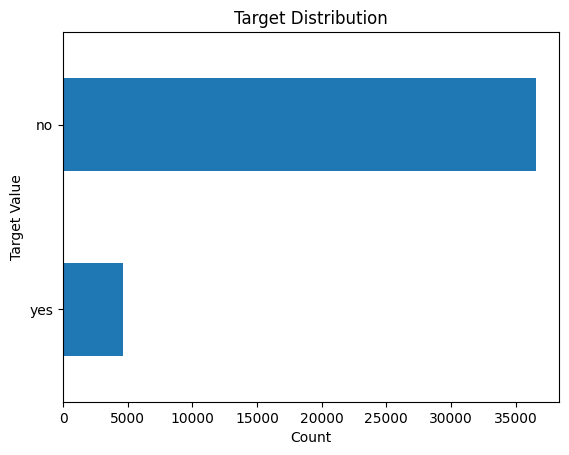

In [14]:
# Data is extremely imbalanced
ax=df.y.value_counts().sort_values().plot(kind = 'barh')
ax.set_xlabel("Count")
ax.set_ylabel("Target Value")
ax.set_title("Target Distribution")

### Engineering Features & Data Preparation

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('y', axis=1), df[['y']], 
                                                   random_state = 100)


In [19]:
num_feature=df.select_dtypes(include=['int64','float64']).columns
cate_feature=df.drop('y', axis=1).select_dtypes(include='object').columns

In [20]:
# Examine the cardinality of categorical feature
df[cate_feature].nunique()

job            12
marital         4
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
dtype: int64

In [21]:
# For high cardinality category, use ordinal:
high_cate=['job', 'marital', 'education', 'month', 'day_of_week']
low_cate=['default','housing', 'loan', 'contact', 'poutcome']

In [22]:
# building pipeline transformation
num_transformer=Pipeline([
    ('scaler', StandardScaler())
])

high_cate_transfomer= Pipeline([
    ("ordinal_encoder", OrdinalEncoder()),
    ("selector", SelectPercentile(chi2, percentile=50))
])

low_cate_transformer=Pipeline([
    ("One_hot_encoder", OneHotEncoder(handle_unknown='ignore')),
    ("selector", SelectPercentile(chi2, percentile=50))
])

preprocessor= ColumnTransformer([
    ("num", num_transformer, num_feature),
    ("high_cardinality_cate", high_cate_transfomer, high_cate),
    ("low_cardinality_cate", low_cate_transformer, low_cate)
]
)

In [25]:
# Fitting a Logistics Regression
clf=Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression())
])

# setting weight for imbalanced data
weights = np.linspace(0.5,0.99,10)

#LogisticRegression
params_log = { 'clf__max_iter':[100, 200 ,300],
         'clf__C' : [100, 10, 1.0, 0.1, 0.01],
         'clf__class_weight':[{'yes':x, 'no':1.0-x} for x in weights]}
         

grid_logi = GridSearchCV(clf, param_grid=params_log).fit(X_train, y_train)
# grid_score_train = grid.score(X_train, y_train)
# grid_score_test = grid.score(X_test, y_test)

/Users/markpeng/.pyenv/versions/3.8.15/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markpeng/.pyenv/versions/3.8.15/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/markpeng/.pyenv/versions/3.8.15/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was

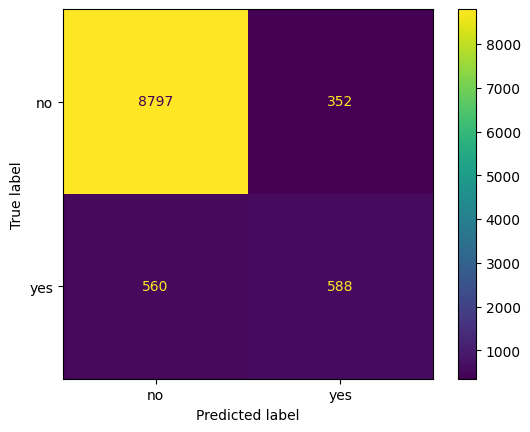

In [29]:
cm=confusion_matrix(y_test, grid_logi.predict(X_test), labels=grid_logi.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=grid_logi.classes_)
disp.plot()
plt.show()

In [30]:
grid_logi.best_params_

{'clf__C': 0.1,
 'clf__class_weight': {'yes': 0.6088888888888889, 'no': 0.3911111111111111},
 'clf__max_iter': 100}

In [74]:
acc_log=accuracy_score(y_test,grid_logi.predict(X_test))
print("Accuracy on Test for Logistics: "+ str(acc_log))

Accuracy on Test for Logistics: 0.9114305137418666


#### K Nearest Neighbors 

In [61]:
# Fitting a KNN algorithm
clf_knn=Pipeline([
    ('preprocessor', preprocessor),
    ('clf', KNeighborsClassifier())
])

params_knn = {'clf__n_neighbors': [5,8,10,15,20,30],
                'clf__weights':['distance'],
                'clf__leaf_size' : [20,30,40,50,60],
                'clf__p': [1,2]
                }
         

grid_knn = GridSearchCV(clf_knn, param_grid=params_knn).fit(X_train, y_train)
# grid_score_train = grid.score(X_train, y_train)
# grid_score_test = grid.score(X_test, y_test)


/Users/markpeng/.pyenv/versions/3.8.15/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/markpeng/.pyenv/versions/3.8.15/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/markpeng/.pyenv/versions/3.8.15/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/markpeng/.pyenv/versions/3.8.15/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A

In [62]:
grid_knn.best_params_

{'clf__leaf_size': 20,
 'clf__n_neighbors': 20,
 'clf__p': 2,
 'clf__weights': 'distance'}

In [71]:
acc_knn=accuracy_score(y_test,grid_knn.predict(X_test))
print("Accuracy on Test for KNN: "+ str(acc_knn))

Accuracy on Test for KNN: 0.9065747305040303


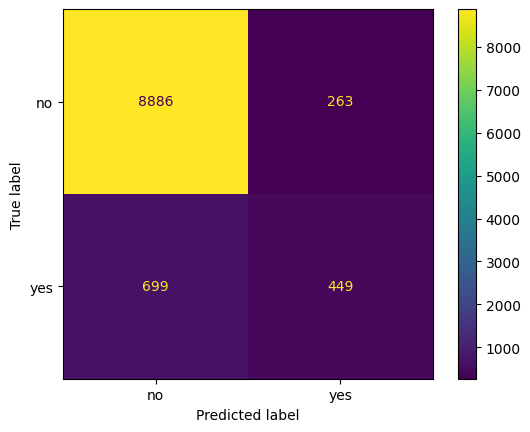

In [89]:
cm=confusion_matrix(y_test, grid_knn.predict(X_test), labels=grid_knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=grid_knn.classes_)
disp.plot()
plt.show()

#### Decision Tree

In [92]:
# Fitting a Decision Tree
clf_dc=Pipeline([
    ('preprocessor', preprocessor),
    ('clf', DecisionTreeClassifier())
])

params_dt = {'clf__max_depth': [5,10,15,20,30,40],
                'clf__min_samples_split':[2,6,8,10,12,15,20],
                'clf__min_samples_leaf' : [1, 2,6,8,10,12,15,20],
                }
         

grid_dc = GridSearchCV(clf_dc, param_grid=params_dt).fit(X_train, y_train)
# grid_score_train = grid.score(X_train, y_train)
# grid_score_test = grid.score(X_test, y_test)


In [93]:
grid_dc.best_params_

{'clf__max_depth': 5, 'clf__min_samples_leaf': 12, 'clf__min_samples_split': 8}

In [94]:
# print("Accuracy on Train: "+ str(grid_logi.score(X_train,y_train)))
acc_dc=accuracy_score(y_test,grid_dc.predict(X_test))
print("Accuracy on Test for Decision Tree: "+ str(acc_dc))


Accuracy on Test for Decision Tree: 0.9135670583665145


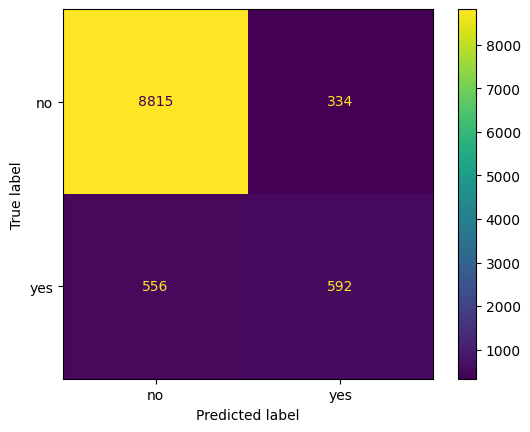

In [95]:
cm=confusion_matrix(y_test, grid_dc.predict(X_test), labels=grid_dc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=grid_dc.classes_)
disp.plot()
plt.show()

#### Support Vector Machine

In [80]:
from scipy.stats import reciprocal, uniform


In [85]:
# Fitting a Decision Tree
clf_svc=Pipeline([
    ('preprocessor', preprocessor),
    ('clf', SVC())
])

# setting weight for imbalanced data
weights = np.linspace(0.5,0.99,5)

params_svc = {'clf__C': [.01,1,3,10],
                # 'clf__gamma': [reciprocal(0.001, 0.1)],
                # 'clf__kernel': ['linear', 'poly', 'rbf'],
                'clf__class_weight':[{'yes': 0.6088888888888889, 'no': 0.3911111111111111}]}
                
         

grid_svc = GridSearchCV(clf_svc, param_grid=params_svc).fit(X_train, y_train)
# grid_score_train = grid.score(X_train, y_train)
# grid_score_test = grid.score(X_test, y_test)


/Users/markpeng/.pyenv/versions/3.8.15/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markpeng/.pyenv/versions/3.8.15/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markpeng/.pyenv/versions/3.8.15/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markpeng/.pyenv/versions/3.8.15/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A colu

In [86]:
grid_svc.best_params_

{'clf__C': 1,
 'clf__class_weight': {'yes': 0.6088888888888889, 'no': 0.3911111111111111}}

In [87]:
# print("Accuracy on Train: "+ str(grid_logi.score(X_train,y_train)))
acc_svc=accuracy_score(y_test,grid_svc.predict(X_test))
print("Accuracy on Test for Decision Tree: "+ str(acc_svc))


Accuracy on Test for Decision Tree: 0.9125959017189472


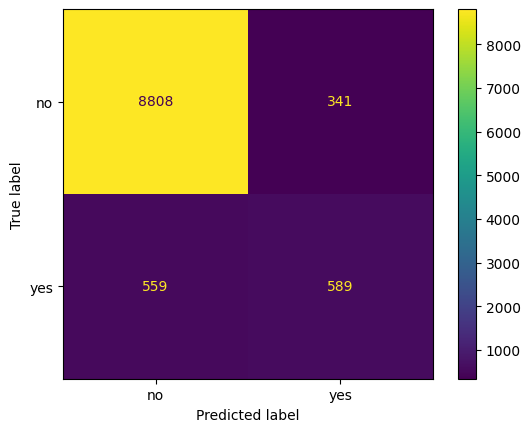

In [117]:
cm=confusion_matrix(y_test, grid_svc.predict(X_test), labels=grid_svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=grid_svc.classes_)
disp.plot()
plt.show()

##### Model Comparison

In [98]:
res_dict = {'model': ['Logistic Regression','KNN','Decision Tree', 'SVC', ],
           'test_score': [acc_log, acc_knn, acc_dc, acc_svc],
           'average_fit_time': ['4m52', '1m48', '5m21', '1m41']}
results_df = pd.DataFrame(res_dict).set_index('model')

In [111]:
results_df

,test_score,average_fit_time
model,,
Logistic Regression,0.911431,4m52
KNN,0.906575,1m48
Decision Tree,0.913567,5m21
SVC,0.912596,1m41


##### As we can see above, the model training time varies depend on the complexity of the model as well as the hyper-parameter searching space. For simple model such as logistics regression, the tunning time is relatively low even the searching space is quite large. However, for SVC on the other hand, this is a much intense and computational heavy algorithm which took more than 1 hours to run for my initial search space. Therefore, I had to reduce the dimension of the search space which ended up with 1m41 running time. 

#### In terms of performance, all 4 models has similar performance when comparing testing score as well as confusion matrix. However, Decision tree seems to be the most efficient model due to computation time (although it took longer but search space is also much higher than other 3 models)

### Potential Improvement of the model

#### Here are a couple things that we can further pursue for model improvement. One thing we could potentially do is under-sampling or over-sampling due to the imbalance dataset. By doing so, we will have a more balance data so algorithm will have learn the feature in the balance fashion. Other things we could consider is ensemble modling such as XGboost and Random Forest as those algorithm is more robust than Decision Tree. Third, we could also consider tunning the parameters with greater range. Especially for class_weight parameter that we should consider carefully on putting more weight on minority over the majority class.